Using compute device: cuda
Loading dataset from data/mega_train.csv...
Loaded 216919 samples.
Loading dataset from data/mega_val.csv...
Loaded 27481 samples.

--- Starting Training ---
Epoch 1/10 | Train MSE: 0.8435 | Val MSE: 0.6238 | PCC: 0.5165 | SCC: 0.4552 | Time: 54.2s
Epoch 2/10 | Train MSE: 0.6179 | Val MSE: 0.6048 | PCC: 0.5578 | SCC: 0.5115 | Time: 54.0s
Epoch 3/10 | Train MSE: 0.4720 | Val MSE: 0.5869 | PCC: 0.5703 | SCC: 0.5223 | Time: 54.1s
Epoch 4/10 | Train MSE: 0.3788 | Val MSE: 0.6140 | PCC: 0.5467 | SCC: 0.4901 | Time: 54.6s
Epoch 5/10 | Train MSE: 0.3229 | Val MSE: 0.6037 | PCC: 0.5554 | SCC: 0.5029 | Time: 54.9s
Epoch 6/10 | Train MSE: 0.2853 | Val MSE: 0.6217 | PCC: 0.5487 | SCC: 0.4883 | Time: 55.1s
Epoch 7/10 | Train MSE: 0.2577 | Val MSE: 0.6262 | PCC: 0.5403 | SCC: 0.4821 | Time: 54.6s
Epoch 8/10 | Train MSE: 0.2364 | Val MSE: 0.6303 | PCC: 0.5432 | SCC: 0.4849 | Time: 55.0s
Epoch 9/10 | Train MSE: 0.2172 | Val MSE: 0.6415 | PCC: 0.5338 | SCC: 0.4769 | Time: 54

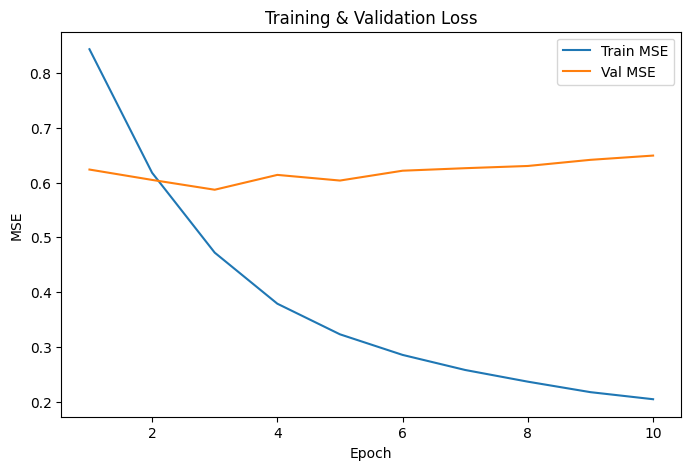

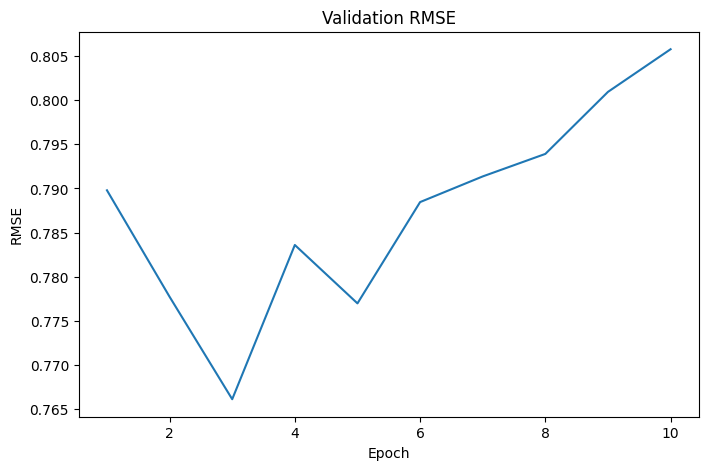

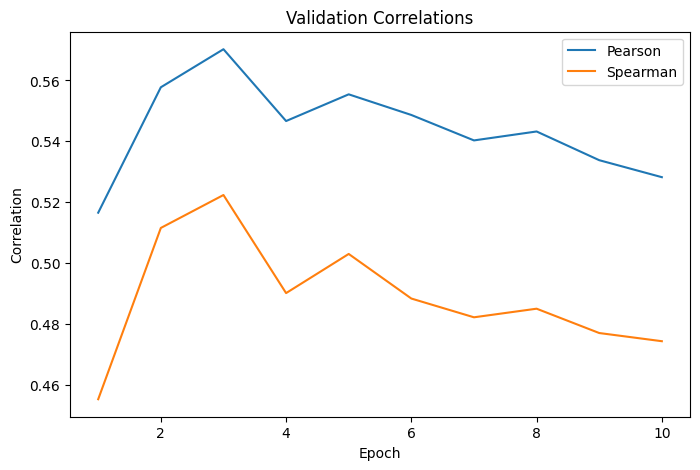

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import time

# -------------------------------------------------------------------
# 1. Tokenizer
# -------------------------------------------------------------------
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AMINO_ACIDS)}
PAD_IDX = 0
UNK_IDX = 21

def encode_sequence(seq, max_len=120):
    encoded = [AA_TO_IDX.get(aa, UNK_IDX) for aa in seq]
    if len(encoded) < max_len:
        encoded = encoded + [PAD_IDX] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

# -------------------------------------------------------------------
# 2. PyTorch Dataset
# -------------------------------------------------------------------
class ProteinStabilityDataset(Dataset):
    def __init__(self, csv_file, max_len=120):
        print(f"Loading dataset from {csv_file}...")
        self.data = pd.read_csv(csv_file)
        self.max_len = max_len
        print(f"Loaded {len(self.data)} samples.")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        wt_seq = row['wt_seq']
        mut_seq = row['aa_seq']
        ddg = row['ddG_ML']
        
        wt_encoded = torch.tensor(encode_sequence(wt_seq, self.max_len), dtype=torch.long)
        mut_encoded = torch.tensor(encode_sequence(mut_seq, self.max_len), dtype=torch.long)
        target = torch.tensor(ddg, dtype=torch.float32)
        
        return wt_encoded, mut_encoded, target

# -------------------------------------------------------------------
# 3. The Siamese LSTM Model
# -------------------------------------------------------------------
class SiameseProteinLSTM(nn.Module):
    def __init__(self, vocab_size=22, embed_dim=64, hidden_dim=128, num_layers=2):
        super(SiameseProteinLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        
    def forward_one_branch(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        final_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return final_state

    def forward(self, wt_seq, mut_seq):
        wt_features = self.forward_one_branch(wt_seq)
        mut_features = self.forward_one_branch(mut_seq)
        diff = mut_features - wt_features
        ddg_prediction = self.fc(diff)
        return ddg_prediction.squeeze(1)

# -------------------------------------------------------------------
# 4. Training and Validation Loop with Metrics + PLOTS
# -------------------------------------------------------------------
def train_and_evaluate():

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using compute device: {device}")
    
    train_dataset = ProteinStabilityDataset('data/mega_train.csv', max_len=120)
    val_dataset = ProteinStabilityDataset('data/mega_val.csv', max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    
    model = SiameseProteinLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 10

    # --------------------------
    # Store metrics per epoch
    # --------------------------
    train_losses = []
    val_losses = []
    val_rmses = []
    pearsons = []
    spearmans = []
    
    print("\n--- Starting Training ---")
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # TRAIN
        model.train()
        total_train_loss = 0.0
        
        for wt, mut, target in train_loader:
            wt, mut, target = wt.to(device), mut.to(device), target.to(device)
            
            optimizer.zero_grad()
            predictions = model(wt, mut)
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # VALIDATION
        model.eval()
        total_val_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for wt, mut, target in val_loader:
                wt, mut, target = wt.to(device), mut.to(device), target.to(device)
                
                predictions = model(wt, mut)
                loss = criterion(predictions, target)
                total_val_loss += loss.item()
                
                all_preds.extend(predictions.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                
        avg_val_loss = total_val_loss / len(val_loader)
        rmse = np.sqrt(avg_val_loss)
        pcc, _ = pearsonr(all_targets, all_preds)
        scc, _ = spearmanr(all_targets, all_preds)
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_rmses.append(rmse)
        pearsons.append(pcc)
        spearmans.append(scc)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train MSE: {avg_train_loss:.4f} | "
              f"Val MSE: {avg_val_loss:.4f} | "
              f"PCC: {pcc:.4f} | SCC: {scc:.4f} | "
              f"Time: {epoch_time:.1f}s")

    # -------------------------------------------------------------------
    # 5. PLOT METRICS
    # -------------------------------------------------------------------
    epochs_range = range(1, epochs+1)

    # Loss Plot
    plt.figure(figsize=(8,5))
    plt.plot(epochs_range, train_losses, label='Train MSE')
    plt.plot(epochs_range, val_losses, label='Val MSE')
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    # RMSE Plot
    plt.figure(figsize=(8,5))
    plt.plot(epochs_range, val_rmses)
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Validation RMSE")
    plt.show()

    # Correlation Plot
    plt.figure(figsize=(8,5))
    plt.plot(epochs_range, pearsons, label='Pearson')
    plt.plot(epochs_range, spearmans, label='Spearman')
    plt.xlabel("Epoch")
    plt.ylabel("Correlation")
    plt.title("Validation Correlations")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    train_and_evaluate()